# Assignment 7: Q-Learning (Solution)
---
In this assignment, we will solve a classic control problem called Mountain Car using OpenAI Gym ([link](https://gym.openai.com/envs/MountainCar-v0/)). The goal is to drive the car to reach the top of the hill marked by a yellow flag. To achieve that, we need to steer the car back and forth to gain enough momentum. We will use Q-Learning algorithm ([Link](https://en.wikipedia.org/wiki/Q-learning)) to solve the task.

<p align="center">
  <img src="https://user-images.githubusercontent.com/96804013/153467131-a630edb2-aeb9-4694-bd69-28382b49c25a.gif")
"/>
</p>

<p align="center">
  <em>Figure 1: Performance of an untrained car.</em>
</p>

<p align="center">
  <img src="https://user-images.githubusercontent.com/96804013/153467239-0e681df2-0f79-4453-81e0-b2ac1e9fd378.gif")
"/>
</p>

<p align="center">
  <em>Figure 2: Performance of a trained car.</em>
</p>



In [ ]:
import time
import random
import numpy as np 
import matplotlib.pyplot as plt 
import gym 
env = gym.make("MountainCar-v0")

## The MountainCar-v0 Environment 
---

<p align="center">
  <img src="https://user-images.githubusercontent.com/96804013/152835304-fa8af20e-d6c5-4b41-b36e-21b1ebe66240.png")
"/>
</p>

<p align="center">
  <em>Figure 3: RL pipeline. </em>
</p>

<br>

First, let's get familiar with the terminology of the MountainCar-v0 environment.



__Actions:__ 
  - 0 =	push left
  - 1 =	no push
  - 2 =	push right

__Observations (states):__ 
  - Position
  - Velocity

__Reward:__ 
  - `-1` for each timestep the agent spends in the environment until the termination of an episode
  - The goal of the agent is to solve the task as quickly as possible
  
__Other terminology:__

- Step = agent taking one action in the environment
- Done = flag of the termination of the current episode

<br>

Let's import necessary packages/libraries and specify the environment. 
                    
                    import time
                    import random
                    import numpy as np 
                    import matplotlib.pyplot as plt 
                    import gym 
                    env = gym.make("MountainCar-v0")


Next, let's check the values of some variable. 

                    random_action = env.action_space.sample() 
                    env.reset() 
                    observation, reward, done, info = env.step(random_action)

                    print(f"Action = {random_action}")
                    print(f"Observation = {observation}, shape = {observation.shape}")
                    print(f"Reward = {reward}")
                    print(f"Done = {done}")

                    print(f"Number of available actions = {env.action_space.n}")
                    print(f"Observation space: \n min = {env.observation_space.low} \n max = {env.observation_space.high}")


The observation space (position and velocity) is continuous. We need to discretize the space in order to build a Q table.

                    # Discretize the observation space to 20 bins
                    num_position = 20
                    num_velocity = 20 
                    pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num_position)
                    vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num_velocity)

                    print(f"Discretized position space: {len(pos_space)}\n{pos_space}")
                    print(f"Discretized velocity space: {len(vel_space)}\n{vel_space}")

                    observations = []
                    for pos in range(num_position):
                      for vel in range(num_velocity):
                        observations.append((pos, vel))

                    # Q table is implemented as a dictionary where key = [observation, action], value = Q value
                    q_table = {}
                    for state in observations:
                      for action in [0, 1, 2]:
                        q_table[state, action] = 0

                    print(f"Total observations: {len(observations)}")
                    print(f"Total elements of the Q table: {len(q_table)}")

In [ ]:
#@title Default title text
random_action = env.action_space.sample() 
env.reset() 
observation, reward, done, info = env.step(random_action)

print(f"Action = {random_action}")
print(f"Observation = {observation}, shape = {observation.shape}")
print(f"Reward = {reward}")
print(f"Done = {done}")

print(f"Number of actions that can be taken = {env.action_space.n}")
print(f"Limits of the observation: \n max ={env.observation_space.low} \n min ={env.observation_space.high[0]}")

Action = 1
Observation = [-5.08021725e-01 -1.17666891e-04], shape = (2,)
Reward = -1.0
Done = False
Number of actions that can be taken = 3
Limits of the observation: 
 max =[-1.2  -0.07] 
 min =0.6000000238418579


In [ ]:
num_position = 20
num_velocity = 20 

# Discretize to 20 buckets each from continous observations
pos_space = np.linspace(-1.2, 0.6, num_position)
vel_space = np.linspace(-0.07, 0.07, num_velocity)

print(f"Discretized position space: {len(pos_space)}\n{pos_space}")
print(f"Discretized velocity space:{len(vel_space)}\n{vel_space}")

observations = []
for pos in range(num_position):
  for vel in range(num_velocity):
    observations.append((pos, vel))

# Q table is implemented as a dictionary data structure
# Where key = [observation, action], value = Q-value
q_table = {}
for state in observations:
  for action in [0, 1, 2]:
   q_table[state, action] = 0

print(f"\nTotal possible observations: {len(observations)}")
print(f"Size of q_table: {len(q_table)}")

Discretized position space: 20
[-1.2        -1.10526316 -1.01052632 -0.91578947 -0.82105263 -0.72631579
 -0.63157895 -0.53684211 -0.44210526 -0.34736842 -0.25263158 -0.15789474
 -0.06315789  0.03157895  0.12631579  0.22105263  0.31578947  0.41052632
  0.50526316  0.6       ]
Discretized velocity space:20
[-0.07       -0.06263158 -0.05526316 -0.04789474 -0.04052632 -0.03315789
 -0.02578947 -0.01842105 -0.01105263 -0.00368421  0.00368421  0.01105263
  0.01842105  0.02578947  0.03315789  0.04052632  0.04789474  0.05526316
  0.06263158  0.07      ]

Total possible observations: 400
Size of q_table: 1200


The Q table looks like the following.

<p align="center">
  <img src="https://user-images.githubusercontent.com/96804013/153719045-4da1d0a1-25ba-4b69-94e9-b0ee67a288fa.jpg")
"/>
</p>

<p align="center">
  <em>Figure 4: Q table with random values.</em>
</p>

<br>

Next, let's implement two helper functions. 

__make_discrete__: convert continuous observation (position and velocity) into their discrete bins.  

__get_greedy_action__: select the best action using the Q table learned so far. 

                    def make_discrete(observation):
                      pos, vel =  observation
                      pos_bin = int(np.digitize(pos, pos_space))
                      vel_bin = int(np.digitize(vel, vel_space))
                      return (pos_bin, vel_bin)

                    def get_greedy_action(q_table, observation, actions=[0, 1, 2]):
                      values = np.array([q_table[observation,a] for a in actions])
                      greedy_action = np.argmax(values)
                      return greedy_action


In [ ]:
def make_discrete(observation):
  pos, vel =  observation
  pos_bin = int(np.digitize(pos, pos_space))
  vel_bin = int(np.digitize(vel, vel_space))
  return (pos_bin, vel_bin)

def get_greedy_action(q_table, observation, actions=[0, 1, 2]):
  # For the current observation, get the most favorable action
  values = np.array([q_table[observation,a] for a in actions])
  greedy_action = np.argmax(values)
  return greedy_action

---
##Exercise 1

As the first exercise, let's implement the $\epsilon$-greedy strategy for choosing an action. 

Please complete __select_action__ in the following.

                    def select_action(current_exploration_rate, greedy_action):
                      rand_num = ######## YOUR CODE HERE (1) #########

                      if rand_num < current_exploration_rate:
                        action = ######## YOUR CODE HERE (2) #########
                      else: 
                        action = greedy_action

                      return action 

Hints 
  - Sample a random number between 0 and 1 with uniform probability
  - Randomly choose an action (`0`, `1` or `2`) with equal probability

References 
  - random.random ([link](https://www.w3schools.com/python/ref_random_random.asp))
  - random.choice ([link](https://www.w3schools.com/python/ref_random_choice.asp))

In [ ]:
def select_action(current_exploration_rate, greedy_action):
  # Enforce that exploration_rate % of actions are taken at random
  # randomly sample a number between 0 and 1
  rand_num = random.random() # Flip a coin

   # if the number is less than exploration rate, take random action 
  if rand_num < current_exploration_rate:
    action = np.random.choice([0,1,2]) # Take action 0, 1 or 2 with equal probability
    #print(f"Random action = {action}")

   # 100*(1 - exploration_rate) % of the time, take action that the q table thinks is best
  else: 
    action = greedy_action

  return action 

Next, we will exponentially decay $\epsilon$ to influence the exploration of the RL agent.

$$\text{For episode n:}$$
$$ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\text{current exploration probability(%)}~=max[~ϵ_{min}, ~ϵ_{start}(ϵ_{decay~rate})^n]. $$

We will start with 100% exploration, then gradually decrease it to 5% (the minimum value).

                  eps_start = 1.0
                  eps_decay_rate = 0.95
                  eps_min = 0.05


In [ ]:
# Exploration params
eps_start = 1.0
eps_decay_rate = 0.99995
eps_min = 0.01 # 1%

# Set environment params
env._max_episode_steps = 1000 # Environment will go to a total of 1000 timesteps per episode
max_episodes = 50000 # Total episode count
learning_rate = 0.1 # Relate to the equatio below
gamma = 0.99 # Relate to the equation below



---
## Exercise 2: 

Next, let's implement the Q-learning algorithm (shown in Figure 5) by first setting some parameters. 

                  env._max_episode_steps = 1000
                  max_episodes = 50000
                  learning_rate = 0.1
                  gamma = 0.99
                
<p align="center">
  <img src="https://user-images.githubusercontent.com/96804013/153653226-b68e09a6-b8db-48f1-80cf-42ad7425dd76.png")
"/>
</p>

<p align="center">
  <em>Figure 5: The Q-Learning algorithm.</em>
</p>

<br>

As the second exercise, please implement the following equation. 

$$Q(S,A) ← Q(S,A) + \alpha[ R + \gamma Q(S', a) - Q(S,A)]$$

                    current_exploration_rate = eps_start
                    reward_collected = []
                    start = time.time()

                    for i in range(max_episodes):
                      timestep = 0 
                      score = 0
                      done = False
                      current_obs = env.reset()
                      current_obs = make_discrete(current_obs)
                      
                      while not done:
                        greedy_action = get_greedy_action(q_table, current_obs)

                        action = select_action (current_exploration_rate, greedy_action)
                        obs_next, reward, done, info = env.step(action)
                        obs_next = make_discrete(obs_next)

                        action_next = get_greedy_action(q_table, obs_next)

                        q_table[current_obs, action] = ########### YOUR CODE HERE ##########
                        timestep += 1
                        score += reward
                        current_obs = obs_next
                        
                      if i % 100 == 0:
                        print(f"Episode {i}: Exploration rate = {round(current_exploration_rate,3)}, completed with {timestep} timesteps, score = {score}")
                        reward_collected.append(score)
                      
                      current_exploration_rate = max(eps_min, current_exploration_rate*eps_decay_rate)
      
                    print(f"total training time = {time.time() - start} seconds")



In [ ]:
"""
Main training loop 
"""

# Set starting values
current_exploration_rate = eps_start
reward_collected = []
start = time.time()

for i in range(max_episodes):
  
  # Set counters/ flags
  timestep = 0 
  score = 0
  done = False

  # Reset the environment to get the first observation
  current_obs = env.reset()
  current_obs = make_discrete(current_obs)

  # Enter a loop (till the end of timesteps --> 1000)
  while not done:
    # For current observation, get the action that the q_table thinks is best
    greedy_action = get_greedy_action(q_table, current_obs)

    # Apply exploration to that action
    action = select_action(current_exploration_rate, greedy_action)
    
    # Take a step in the environment and discretize the observtion
    obs_next, reward, done, info = env.step(action)
    obs_next = make_discrete(obs_next)

    # For next observation, get the action that the q_table thinks is best
    action_next = get_greedy_action(q_table, obs_next)

    # Perform the main Q-table update operation (look at the equation above)
    q_table[current_obs, action] = q_table[current_obs, action] + \
            learning_rate*(reward + gamma*q_table[obs_next, action_next] - q_table[current_obs, action])
    
    # Update counters
    timestep += 1
    score += reward

    # For the next timestep, current observation <<-- next observation of this timstep
    current_obs = obs_next
    # End of while loop (when does it end?)

  # Out of the while loop (print and collect reward every 100 episodes)
  if i % 100 == 0:
    print(f"Episode {i}: Exploration rate = {round(current_exploration_rate,3)}, completed with {timestep} timesteps, score = {score}")
    reward_collected.append(score)

  # Update the exploration rate after very episode ends
  current_exploration_rate = max(eps_min, current_exploration_rate*eps_decay_rate)
  
print(f"total training time = {time.time() - start} seconds")

Episode 0: Exploration rate = 1.0, completed with 1000 timesteps, score = -1000.0
Episode 100: Exploration rate = 0.995, completed with 1000 timesteps, score = -1000.0
Episode 200: Exploration rate = 0.99, completed with 1000 timesteps, score = -1000.0
Episode 300: Exploration rate = 0.985, completed with 1000 timesteps, score = -1000.0
Episode 400: Exploration rate = 0.98, completed with 1000 timesteps, score = -1000.0
Episode 500: Exploration rate = 0.975, completed with 1000 timesteps, score = -1000.0
Episode 600: Exploration rate = 0.97, completed with 1000 timesteps, score = -1000.0
Episode 700: Exploration rate = 0.966, completed with 1000 timesteps, score = -1000.0
Episode 800: Exploration rate = 0.961, completed with 1000 timesteps, score = -1000.0
Episode 900: Exploration rate = 0.956, completed with 1000 timesteps, score = -1000.0
Episode 1000: Exploration rate = 0.951, completed with 1000 timesteps, score = -1000.0
Episode 1100: Exploration rate = 0.946, completed with 1000 

Now, let's plot the reward. An example plot is shown in Figure 6. 

                    fig, ax = plt.subplots(figsize = (10,5))
                    x = len(reward_collected)
                    ax.plot(range(x), reward_collected)
                    ax.set_title(f"Reward Collected over {x*100} episodes")
                    ax.set_xlabel("Episodes")
                    ax.set_ylabel("Reward per episode")

                    x_labels = [f"{int(i/1000)}k" for  i in range(0, 100*x + 1, 1000)]
                    ax.set_xticklabels(x_labels);

<p align="center">
  <img src="https://user-images.githubusercontent.com/96804013/163268608-5452d1b1-069f-4741-86a1-2b5969cdd1c5.png")
"/>
</p>

<p align="center">
  <em>Figure 6: Example reward plot: the RL agent eventually learned to solve the control task (complete an episode) within 200 timesteps.</em>
</p>

Text(0, 0.5, 'Reward per episode')

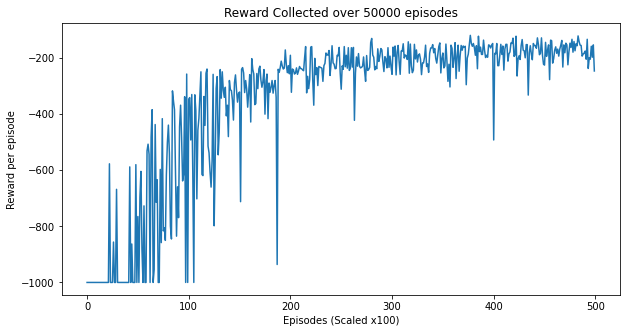

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
x = len(reward_collected)
ax.plot(range(x), reward_collected)
ax.set_title(f"Reward Collected over {x*100} episodes")
ax.set_xlabel("Episodes (Scaled x100)")
ax.set_ylabel("Reward per episode")

#x_labels = ["0k", "10k", "20k", "30k", "40k", "50k"] # If episode count changes, change this accordingly
#ax.set_xticklabels(x_labels);

The increase in the `reward collected per episode` as the episodes progress is a good indicator that the agent is learning. 

Lastly, let's use the code below to render a rollout of agent performing the task.


                    !pip install gym pyvirtualdisplay > /dev/null 2>&1
                    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
                    !pip install colabgymrender==1.0.2

---

                    from colabgymrender.recorder import Recorder 

                    env = gym.make("MountainCar-v0")
                    env = Recorder(env, './video')

                    done = False 
                    current_observation = env.reset() 
                    
                    while not done:
                      action = select_action(current_exploration_rate, q_table, current_observation)
                      observation_next, reward, done, info = env.step(action)
                      current_observation = observation_next


In [ ]:
# Install some dependencies to record environment render
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

  Created wheel for colabgymrender: filename=colabgymrender-1.0.2-py3-none-any.whl size=2446 sha256=abf7ab9c916ed98826684ae886aaac401ce002addd78608d44dec6b5630c64be
  Stored in directory: /root/.cache/pip/wheels/1f/56/73/3697080da5fc7b120516aef37d1d1eb2380515ba9e272b8ccd
Successfully built colabgymrender


In [ ]:
from colabgymrender.recorder import Recorder 

# Set the recorder
env = gym.make("MountainCar-v0")
env = Recorder(env, './video')

# Starting values
done = False 
current_observation = env.reset() 
current_observation = make_discrete(current_observation)

while not done:
  # Get best action from agent (I have set no exploration at test time, how would you enforce exploration?)
  greedy_action = get_greedy_action(q_table, current_observation)

  # Take a step
  observation_next, reward, done, info = env.step(greedy_action)
  observation_next = make_discrete(observation_next)
  # Pass on info for next timestep
  current_observation = observation_next

env.play()

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2670592/45929032 bytes (5.8%)5980160/45929032 bytes (13.0%)9011200/45929032 bytes (19.6%)11821056/45929032 bytes (25.7%)14794752/45929032 bytes (32.2%)18423808/45929032 bytes (40.1%)21856256/45929032 bytes (47.6%)25059328/45929032 bytes (54.6%)27942912/45929032 bytes (60.8%)30777344/45929032 bytes (67.0%)33751040/45929032 bytes (73.5%)37060608/45929032 bytes (80.7%)

100%|█████████▉| 201/202 [00:01<00:00, 119.12it/s]
